# 导入所需库

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 特征提取函数

In [4]:
def detectAndDescribe(image):
    descriptor = cv2.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

# KNN匹配点

In [5]:
def matchKeyPointsKNN(featuresA, featuresB, ratio):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    # print("Raw matches (knn):", len(rawMatches))
    matches = []
    for m, n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    # print(f"knn匹配的特征点数量:{len(matches)}")
    return matches

# 计算透视关系

In [6]:
def getHomography(kpsA, kpsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                                         reprojThresh)
        return (matches, H, status)
    else:
        return None

# 计算单应行矩阵

In [51]:
def hw04handle(path1, path2, isShow=False):
    # 读取图片
    if isinstance(path2, str):
        imageA = cv2.imread(path2)
        imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
    else:
        imageA = path2
    imageA = cv2.resize(imageA, (1024, 768))
    imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
    if isinstance(path1, str):
        imageB = cv2.imread(path1)
        imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
    else:
        imageB = path1
    t = np.size(imageB)
    imageB = cv2.resize(imageB, (1024, 768))
    imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
    
    # 显示输入的两张图片

    if isShow:
        f = plt.figure(figsize=(10, 4))
        f.add_subplot(1, 2, 1)
        plt.title("imageB")
        plt.imshow(imageB)
        plt.xticks([]), plt.yticks([])
        f.add_subplot(1, 2, 2)
        plt.title("imageA")
        plt.imshow(imageA)
        plt.xticks([]), plt.yticks([])

    # 提取两证图片的特征

    kpsA, featuresA = detectAndDescribe(imageA_gray)
    kpsB, featuresB = detectAndDescribe(imageB_gray)

    # 显示关键点

    if isShow:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=False)
        ax1.imshow(cv2.drawKeypoints(imageA_gray, kpsA, None, color=(0, 255, 0)))
        ax1.set_xlabel("(a)key point", fontsize=14)
        ax2.imshow(cv2.drawKeypoints(imageB_gray, kpsB, None, color=(0, 255, 0)))
        ax2.set_xlabel("(b)key point", fontsize=14)


    # 进行特征匹配

    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75)
    if len(matches) < 10:
        return None
    img3 = cv2.drawMatches(imageA, kpsA, imageB, kpsB, np.random.choice(matches, 100),
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # 匹配的特征展示

    if isShow:
        fig = plt.figure(figsize=(10, 4))
        plt.imshow(img3)
        plt.title("feature match")
        plt.axis('off')

    # 计算两张图的透视关系
    matchCount = len(matches)
    M = getHomography(kpsA, kpsB, matches, reprojThresh=4)
    if M is None:
        print("Error!")
    (matches, H, status) = M


    # 将img1变换到img2的平面
    print(imageA.shape)
    height, width = imageB.shape[:2]
    im_out = cv2.warpPerspective(imageA, H, (width, height))
    # cv2.imwrite("kk.jpg",im_out)

    if isShow:
        fig = plt.figure(figsize=(10, 4))
        plt.imshow(im_out)
        plt.title("transform")
        plt.axis('off')
    
    return matches, H, status


(768, 1024, 3)
[[ 1.85083641e+00 -1.30060322e-01 -1.75463921e+02]
 [ 1.26799166e-01  1.28921188e+00 -9.63629659e+01]
 [ 4.22692633e-04 -6.45419478e-05  1.00000000e+00]]


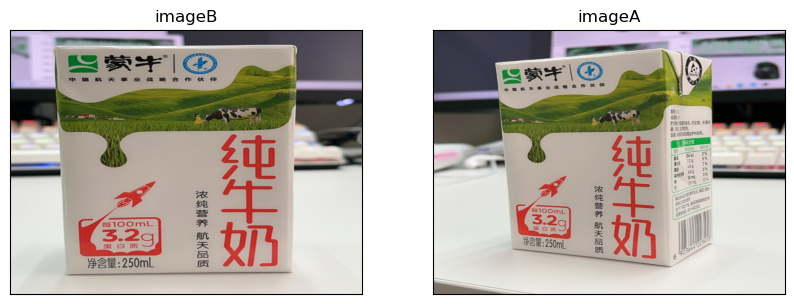

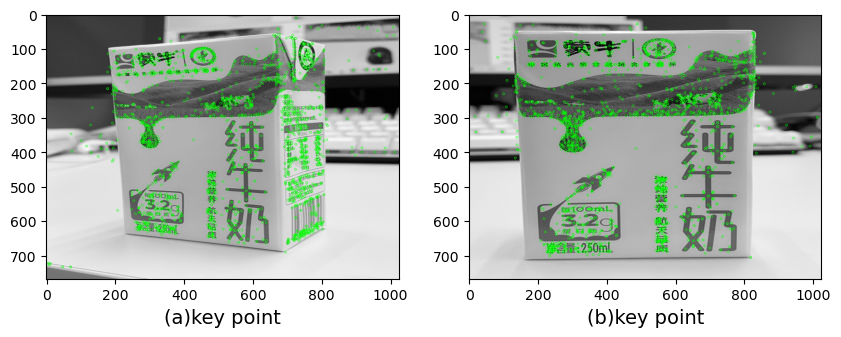

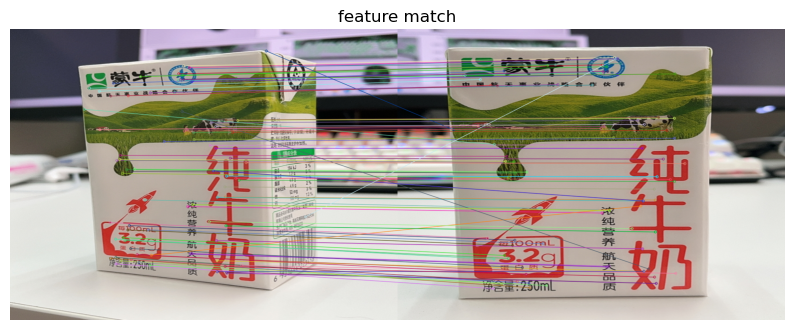

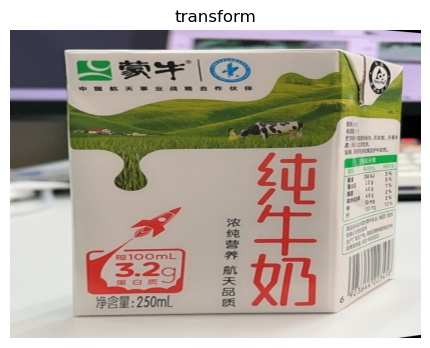

In [52]:
matches, H, status = hw04handle('./img/milk1.png', './img/milk2.png', True)
print(H)